## Import libraries

In [1]:
#First steep is import the libraries. 
import tensorflow as tf
tf.random.set_seed(42)
#Numpy is a lybrary that allow us to work with arrays. 
import numpy as np
#keras is an open source neural networks lybrary writted in python that run's in varios frameworks, TensorFlow included. 
from tensorflow import keras
import matplotlib.pyplot as plt
import pandas as pd
import csv

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from scipy.stats import linregress

#Tranfer learning from tensorhub
import tensorflow_hub as hub

print (tf.__version__)

gEpochs = 100

2.9.0


# Functions


In [2]:
#clear the text 
import re
def cleanText(text):
    whitespace = re.compile(r"\s+")
    web_address = re.compile(r"(?i)http(s):\/\/[a-z0-9.~_\-\/]+")
    user = re.compile(r"(?i)@[a-z0-9_]+")
    text = whitespace.sub(' ', text)
    text = web_address.sub('', text)
    text = user.sub('', text)
    text = re.sub(r"\[[^()]*\]", "", text)
    text = re.sub("\d+", "", text)
    text = re.sub(r'[^\w\s]','',text)
    text = re.sub(r"(?:@\S*|#\S*|http(?=.*://)\S*)", "", text)
    return text.lower()

In [3]:
def get_model(kindmodel):
    switcher = {
        #FLATTEN
        #38s 35ms/step - loss: 0.3960 - accuracy: 0.8109 - val_loss: 1.2877 - val_accuracy: 0.6138
        0:tf.keras.models.Sequential([
              tf.keras.layers.Embedding(total_words, embedding_dim, input_length=max_sequence_len-1),
              tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(lstm_units)),
              tf.keras.layers.Dense(total_words, activation='softmax')]), 
        1:tf.keras.models.Sequential([
            tf.keras.layers.Embedding(total_words, embedding_dim, input_length=max_sequence_len-1), 
            tf.keras.layers.LSTM(100), 
            tf.keras.layers.Dropout(0.1), 
            tf.keras.layers.Dense(total_words, activation='softmax')]),
        
    }
    return switcher.get(kindmodel, None)

In [4]:

def plot_loss_acc(history, validation=True):
    
    '''Plots the training and validation loss and accuracy from a history object'''
    if (validation):
        acc = history.history['accuracy']
        val_acc = history.history['val_accuracy']
        loss = history.history['loss']
        val_loss = history.history['val_loss']

        epochs = range(len(acc))

        plt.plot(epochs, acc, 'bo-', label='Training accuracy')
        plt.plot(epochs, val_acc, 'go-', label='Validation accuracy')
        plt.title('Training and validation accuracy')
        plt.legend()

        plt.figure()

        plt.plot(epochs, loss, 'bo-', label='Training Loss')
        plt.plot(epochs, val_loss, 'go-', label='Validation Loss')
        plt.title('Training and validation loss')
        plt.legend()

        plt.show()
    else:
        acc = history.history['accuracy']
       
        loss = history.history['loss']


        epochs = range(len(acc))

        plt.plot(epochs, acc, 'bo-', label='Training accuracy')

        plt.title('Training accuracy')
        plt.legend()

        plt.figure()


        plt.plot(epochs, loss, 'bo-', label='Training Loss')
        plt.title('Training and  loss')
        plt.legend()

        plt.show() 

In [5]:
def generate_text(seed_text, next_words, model, max_sequence_len):
    output_word = ""
    
    for _ in range(next_words):
        token_list = tokenizer.texts_to_sequences([seed_text])[0]
        token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')
        
        probabilities = model.predict(token_list, verbose=0)
        
        predicted = np.argmax(probabilities, axis=-1)[0]
        
        print (predicted)
        if predicted != 0:
            output_word = tokenizer.index_word[predicted]
            seed_text += " "+output_word
    return seed_text

In [6]:
def opentxt(file):
    data = open(file).read()
    corpus = data.lower().split("\n")
    return corpus


### prepare the data for the model

In [7]:
# Download the dataset
!wget https://storage.googleapis.com/tensorflow-1-public/course3/irish-lyrics-eof.txt


--2022-08-01 18:16:10--  https://storage.googleapis.com/tensorflow-1-public/course3/irish-lyrics-eof.txt
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.17.16, 216.58.215.176, 142.250.200.112, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.17.16|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68970 (67K) [text/plain]
Saving to: ‘irish-lyrics-eof.txt’

irish-lyrics-eof.tx 100%[===================>]  67,35K  --.-KB/s    in 0,03s   

2022-08-01 18:16:10 (2,30 MB/s) - ‘irish-lyrics-eof.txt’ saved [68970/68970]



In [8]:
!mv irish-lyrics-eof.txt ./Data/irish-lyrics-eof.txt

In [9]:
#corpus = opentxt('./Data/irish-lyrics-eof.txt')
corpus = opentxt('./Data/Alice.txt')#

print(corpus[:5])

["alice's adventures in wonderland", '', "                alice's adventures in wonderland", '', '                          lewis carroll']


In [10]:
# Parameters for padding and OOV tokens
trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"

vocab_size = 5700
max_length = 48
embedding_dim = 100
lstm_units = 150
learning_rate = 0.01


In [11]:
# Initialize the Tokenizer class
tokenizer = Tokenizer(num_words = vocab_size)

# Generate the word index dictionary for the training sentences
tokenizer.fit_on_texts(corpus)
word_index = tokenizer.word_index

total_words = len(word_index) + 1

print(f'number of words in word_index: {len(word_index)}')
print (total_words)


number of words in word_index: 2646
2647


In [12]:
input_sequences = []

for line in corpus: 
    clean_sequence = cleanText(line)
    #clean_sequence = line
     
    token_list = tokenizer.texts_to_sequences([clean_sequence])[0]
    for i in range(1, len(token_list)):
        n_gram_sequence = token_list[:i+1]
        
        input_sequences.append(n_gram_sequence)
    
max_sequence_len = max([len(x) for x in input_sequences])
    
input_sequences = np.array(pad_sequences(input_sequences, maxlen=max_sequence_len, padding='pre'))
    
xs, labels = input_sequences[:,:-1],input_sequences[:,-1]

ys = tf.keras.utils.to_categorical(labels, num_classes=total_words)
print (max_sequence_len)
    

16


In [13]:
print (xs[2:])

[[   0    0    0 ...    0    0  423]
 [   0    0    0 ...    0  423   12]
 [   0    0    0 ...    0    0 1490]
 ...
 [   0    0    0 ...    3    1 2646]
 [   0    0    0 ...    1 2646 1471]
 [   0    0    0 ...    0    0    1]]


In [14]:
# Pick element
elem_number = 3


# Print token list and phrase
print(f'token list: {xs[elem_number]}')
print(f'decoded to text: {tokenizer.sequences_to_texts([xs[elem_number]])}')

# Print label
print(f'one-hot label: {ys[elem_number]}')
print(f'index of label: {np.argmax(ys[elem_number])}')

token list: [  0   0   0   0   0   0   0   0   0   0   0   0   0 423  12]
decoded to text: ['adventures in']
one-hot label: [0. 0. 0. ... 0. 0. 0.]
index of label: 699



# Training Models


In [15]:
model0 = get_model(0)

model0.compile(
    loss='categorical_crossentropy', 
    optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate), 
    metrics=['accuracy']
    )

# Print the model summary
model0.summary()

Metal device set to: Apple M1 Pro


2022-08-01 18:16:11.284167: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-08-01 18:16:11.284332: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 15, 100)           264700    
                                                                 
 bidirectional (Bidirectiona  (None, 300)              301200    
 l)                                                              
                                                                 
 dense (Dense)               (None, 2647)              796747    
                                                                 
Total params: 1,362,647
Trainable params: 1,362,647
Non-trainable params: 0
_________________________________________________________________


In [16]:
history0 = model0.fit(xs, ys, epochs=gEpochs)

Epoch 1/100


2022-08-01 18:16:11.772807: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-08-01 18:16:12.791069: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-08-01 18:16:12.964599: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-08-01 18:16:12.976033: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


  1/716 [..............................] - ETA: 17:20 - loss: 7.8823 - accuracy: 0.0000e+00

2022-08-01 18:16:13.084126: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-08-01 18:16:13.110231: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


716/716 [==============================] - 17s 21ms/step - loss: 5.7662 - accuracy: 0.0932
Epoch 2/100
716/716 [==============================] - 15s 21ms/step - loss: 4.9309 - accuracy: 0.1448
Epoch 3/100
716/716 [==============================] - 15s 21ms/step - loss: 4.4023 - accuracy: 0.1766
Epoch 4/100
716/716 [==============================] - 15s 21ms/step - loss: 4.1300 - accuracy: 0.1967
Epoch 5/100
716/716 [==============================] - 15s 21ms/step - loss: 3.5887 - accuracy: 0.2375
Epoch 6/100
716/716 [==============================] - 15s 21ms/step - loss: 3.2151 - accuracy: 0.2814
Epoch 7/100
716/716 [==============================] - 15s 21ms/step - loss: 2.9297 - accuracy: 0.3174
Epoch 8/100
716/716 [==============================] - 15s 21ms/step - loss: 2.6931 - accuracy: 0.3558
Epoch 9/100
716/716 [==============================] - 15s 21ms/step - loss: 2.5270 - accuracy: 0.3849
Epoch 10/100
716/716 [==============================] - 15s 21ms/step - loss: 2.3662 

Epoch 80/100
716/716 [==============================] - 15s 21ms/step - loss: 1.6850 - accuracy: 0.5472
Epoch 81/100
716/716 [==============================] - 15s 21ms/step - loss: 1.7153 - accuracy: 0.5429
Epoch 82/100
716/716 [==============================] - 15s 21ms/step - loss: 1.7022 - accuracy: 0.5449
Epoch 83/100
716/716 [==============================] - 15s 21ms/step - loss: 1.7111 - accuracy: 0.5452
Epoch 84/100
716/716 [==============================] - 15s 21ms/step - loss: 1.6708 - accuracy: 0.5537
Epoch 85/100
716/716 [==============================] - 15s 21ms/step - loss: 1.6665 - accuracy: 0.5557
Epoch 86/100
716/716 [==============================] - 15s 21ms/step - loss: 1.6835 - accuracy: 0.5535
Epoch 87/100
716/716 [==============================] - 15s 21ms/step - loss: 1.6700 - accuracy: 0.5537
Epoch 88/100
716/716 [==============================] - 15s 21ms/step - loss: 1.6670 - accuracy: 0.5553
Epoch 89/100
716/716 [==============================] - 15s 21ms

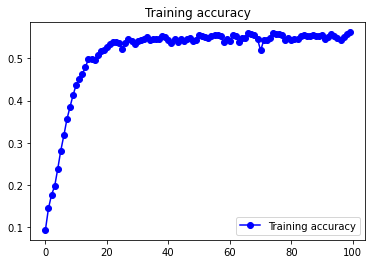

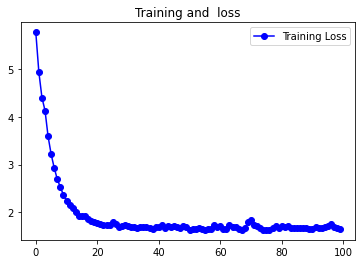

In [17]:
plot_loss_acc(history0, False)

In [18]:
model1 = get_model(1)

model1.compile(
    loss='categorical_crossentropy', 
    optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate), 
    metrics=['accuracy']
    )

# Print the model summary
model1.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 15, 100)           264700    
                                                                 
 lstm_3 (LSTM)               (None, 100)               80400     
                                                                 
 dropout_1 (Dropout)         (None, 100)               0         
                                                                 
 dense_3 (Dense)             (None, 2647)              267347    
                                                                 
Total params: 612,447
Trainable params: 612,447
Non-trainable params: 0
_________________________________________________________________


In [19]:
history1 = model1.fit(xs, ys, epochs=gEpochs)

Epoch 1/100


2022-08-01 18:41:20.648280: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-08-01 18:41:20.753033: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-08-01 18:41:20.815954: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


716/716 [==============================] - 12s 15ms/step - loss: 5.7885 - accuracy: 0.0899
Epoch 2/100
716/716 [==============================] - 11s 15ms/step - loss: 5.0232 - accuracy: 0.1370
Epoch 3/100
716/716 [==============================] - 11s 15ms/step - loss: 4.5322 - accuracy: 0.1692
Epoch 4/100
716/716 [==============================] - 11s 15ms/step - loss: 4.1325 - accuracy: 0.1936
Epoch 5/100
716/716 [==============================] - 11s 15ms/step - loss: 3.8044 - accuracy: 0.2188
Epoch 6/100
716/716 [==============================] - 11s 15ms/step - loss: 3.5152 - accuracy: 0.2477
Epoch 7/100
716/716 [==============================] - 11s 15ms/step - loss: 3.2922 - accuracy: 0.2691
Epoch 8/100
716/716 [==============================] - 11s 15ms/step - loss: 3.1125 - accuracy: 0.2943
Epoch 9/100
716/716 [==============================] - 11s 15ms/step - loss: 2.9597 - accuracy: 0.3134
Epoch 10/100
716/716 [==============================] - 11s 15ms/step - loss: 2.8448 

Epoch 80/100
716/716 [==============================] - 10s 14ms/step - loss: 2.3069 - accuracy: 0.4255
Epoch 81/100
716/716 [==============================] - 10s 14ms/step - loss: 2.3084 - accuracy: 0.4264
Epoch 82/100
716/716 [==============================] - 10s 15ms/step - loss: 2.3128 - accuracy: 0.4244
Epoch 83/100
716/716 [==============================] - 10s 15ms/step - loss: 2.3111 - accuracy: 0.4262
Epoch 84/100
716/716 [==============================] - 10s 14ms/step - loss: 2.3173 - accuracy: 0.4245
Epoch 85/100
716/716 [==============================] - 10s 14ms/step - loss: 2.3198 - accuracy: 0.4241
Epoch 86/100
716/716 [==============================] - 11s 15ms/step - loss: 2.3256 - accuracy: 0.4220
Epoch 87/100
716/716 [==============================] - 10s 14ms/step - loss: 2.2888 - accuracy: 0.4271
Epoch 88/100
716/716 [==============================] - 10s 14ms/step - loss: 2.2972 - accuracy: 0.4299
Epoch 89/100
716/716 [==============================] - 11s 15ms

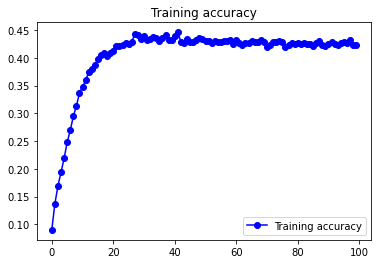

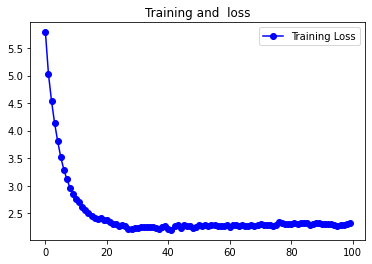

In [20]:
plot_loss_acc(history1, False)

In [27]:
seed_text = "Come here and "
generate_text(seed_text, 1, model1, max_sequence_len)

385


'Come here and  repeated'

In [28]:
generate_text(seed_text, 1, model0, max_sequence_len)

158


'Come here and  look'